In [141]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from PIL import Image
from functools import reduce
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

In [3]:
train_dir = './data/FlagsMashupBot/autoencoder_images/train/0/'
train_files = [f for f in os.listdir(train_dir) if not f.startswith('.')]
val_dir = './data/FlagsMashupBot/autoencoder_images/val/0/'
val_files = [f for f in os.listdir(val_dir) if not f.startswith('.')]
test_dir = './data/FlagsMashupBot/autoencoder_images/test/0/'
test_files = [f for f in os.listdir(test_dir) if not f.startswith('.')]

In [4]:
len(train_files), len(val_files), len(test_files)

(3440, 737, 738)

In [6]:
BATCH_SIZE = 8
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [7]:
train_dir = './data/FlagsMashupBot/autoencoder_images/train/'
val_dir = './data/FlagsMashupBot/autoencoder_images/val/'
test_dir = './data/FlagsMashupBot/autoencoder_images/test/'
image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = image_generator.flow_from_directory(
    train_dir, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    class_mode='input')
val_data_gen = image_generator.flow_from_directory(
    val_dir, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    class_mode='input')
test_data_gen = image_generator.flow_from_directory(
    test_dir, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    class_mode='input')

Found 3440 images belonging to 1 classes.
Found 737 images belonging to 1 classes.
Found 738 images belonging to 1 classes.


In [8]:
im_test = image_generator

In [9]:
a = next(train_data_gen)

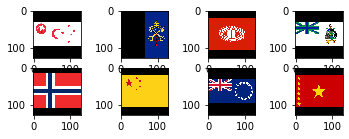

In [10]:
plt.figure()
for i in range(BATCH_SIZE):
    plt.subplot(BATCH_SIZE/2, BATCH_SIZE/2, i+1)
    plt.imshow(a[0][i])

In [11]:
img_width, img_height = IMG_WIDTH, IMG_HEIGHT

In [12]:
input_img = Input(shape=(img_width, img_height, 3))

In [13]:
input_img

<tf.Tensor 'input_1:0' shape=(None, 128, 128, 3) dtype=float32>

In [35]:
conv_shape = (3, 3)

In [36]:
x = Conv2D(16, conv_shape, activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, conv_shape, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, conv_shape, activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [37]:
encoded

<tf.Tensor 'max_pooling2d_8/Identity:0' shape=(None, 16, 16, 8) dtype=float32>

In [38]:
# encoded_flat = Flatten()(encoded)
# lattent_flat = Dense(100, activation='relu')(encoded_flat)
# recoded_flat = Dense(encoded_flat.shape[1], activation='relu')(lattent_flat)
# recoded_3d = Reshape(np.asarray(encoded.shape[1:]))(recoded_flat)

In [32]:
# x = Conv2D(8, conv_shape, activation='relu', padding='same')(recoded_3d)
x = Conv2D(8, conv_shape, activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, conv_shape, activation='sigmoid', padding='same')(x)

In [33]:
decoded

<tf.Tensor 'conv2d_9/Identity:0' shape=(None, 128, 128, 3) dtype=float32>

dimensionality reduction

In [40]:
IMG_HEIGHT * IMG_WIDTH / (reduce(lambda x, y: x*y, np.asarray(encoded.shape[1:])))

8.0

In [41]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 8)         0     

In [43]:
log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = TensorBoard(
    log_dir=log_dir, 
    profile_batch=0)

es_cb = EarlyStopping(
    monitor='val_loss',
    verbose=True,
    patience=12,
    min_delta=0.0001, 
    restore_best_weights=True)

lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=True,
    patience=8,
    mi_delta=0.0001)

cb = [tb_cb, es_cb, lr_cb]

In [44]:
autoencoder_train = autoencoder.fit(
    train_data_gen, 
    epochs=600, 
    shuffle=True,
    validation_data=val_data_gen,
    callbacks=cb)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 430 steps, validate for 93 steps
Epoch 1/500
430/430 [==============================] - 9s 22ms/step - loss: 0.1963 - val_loss: 0.1948
Epoch 2/500
430/430 [==============================] - 7s 16ms/step - loss: 0.1959 - val_loss: 0.1945
Epoch 3/500
430/430 [==============================] - 7s 16ms/step - loss: 0.1956 - val_loss: 0.1941
Epoch 4/500
430/430 [==============================] - 7s 16ms/step - loss: 0.1951 - val_loss: 0.1936
Epoch 5/500
430/430 [==============================] - 7s 16ms/step - loss: 0.1947 - val_loss: 0.1932
Epoch 6/500
430/430 [==============================] - 7s 16ms/step - loss: 0.1942 - val_loss: 0.1927
Epoch 7/500
430/430 [==============================] - 7s 16ms/step - loss: 0.1937 - val_loss: 0.1922
Epoch 8/500
430/430 [==============================] - 7s 16ms/step - loss: 0.1932 - val_loss: 0.1917
Epoch 9/500
430/430 [==============================] - 7s 16ms/step - loss: 0.1927 - val_lo

430/430 [==============================] - 7s 16ms/step - loss: 0.0620 - val_loss: 0.0610
Epoch 79/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0617 - val_loss: 0.0607
Epoch 80/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0613 - val_loss: 0.0604
Epoch 81/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0610 - val_loss: 0.0600
Epoch 82/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0606 - val_loss: 0.0597
Epoch 83/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0603 - val_loss: 0.0594
Epoch 84/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0599 - val_loss: 0.0591
Epoch 85/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0596 - val_loss: 0.0587
Epoch 86/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0593 - val_loss: 0.0584
Epoch 87/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0589 - 

430/430 [==============================] - 7s 16ms/step - loss: 0.0437 - val_loss: 0.0435
Epoch 158/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0435 - val_loss: 0.0433
Epoch 159/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0434 - val_loss: 0.0432
Epoch 160/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0432 - val_loss: 0.0430
Epoch 161/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0431 - val_loss: 0.0429
Epoch 162/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0429 - val_loss: 0.0427
Epoch 163/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0428 - val_loss: 0.0426
Epoch 164/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0427 - val_loss: 0.0425
Epoch 165/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0425 - val_loss: 0.0423
Epoch 166/500
430/430 [==============================] - 7s 16ms/step - loss: 

Epoch 236/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0351 - val_loss: 0.0349
Epoch 237/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0350 - val_loss: 0.0348
Epoch 238/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0349 - val_loss: 0.0347
Epoch 239/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0348 - val_loss: 0.0347
Epoch 240/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0348 - val_loss: 0.0346
Epoch 241/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0347 - val_loss: 0.0345
Epoch 242/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0346 - val_loss: 0.0344
Epoch 243/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0345 - val_loss: 0.0344
Epoch 244/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0345 - val_loss: 0.0343
Epoch 245/500
430/430 [==============================] - 7s 16ms

Epoch 315/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0303 - val_loss: 0.0300
Epoch 316/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0302 - val_loss: 0.0300
Epoch 317/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0302 - val_loss: 0.0299
Epoch 318/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0301 - val_loss: 0.0299
Epoch 319/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0301 - val_loss: 0.0298
Epoch 320/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0300 - val_loss: 0.0298
Epoch 321/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0300 - val_loss: 0.0297
Epoch 322/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0299 - val_loss: 0.0297
Epoch 323/500
430/430 [==============================] - 7s 17ms/step - loss: 0.0299 - val_loss: 0.0296
Epoch 324/500
430/430 [==============================] - 7s 16ms

Epoch 394/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0273 - val_loss: 0.0270
Epoch 395/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0273 - val_loss: 0.0270
Epoch 396/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0273 - val_loss: 0.0270
Epoch 397/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0272 - val_loss: 0.0269
Epoch 398/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0272 - val_loss: 0.0269
Epoch 399/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0272 - val_loss: 0.0269
Epoch 400/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0271 - val_loss: 0.0269
Epoch 401/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0271 - val_loss: 0.0268
Epoch 402/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0271 - val_loss: 0.0268
Epoch 403/500
430/430 [==============================] - 7s 16ms

Epoch 473/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0256 - val_loss: 0.0253
Epoch 474/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0256 - val_loss: 0.0253
Epoch 475/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0255 - val_loss: 0.0252
Epoch 476/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0255 - val_loss: 0.0252
Epoch 477/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0255 - val_loss: 0.0252
Epoch 478/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0255 - val_loss: 0.0252
Epoch 479/500
429/430 [============================>.] - ETA: 0s - loss: 0.0255
Epoch 00479: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
430/430 [==============================] - 7s 16ms/step - loss: 0.0255 - val_loss: 0.0252
Epoch 480/500
430/430 [==============================] - 7s 16ms/step - loss: 0.0255 - val_loss: 0.0252
Epoch 481/500
430/430

In [111]:
# autoencoder.save('./128_model.hdf5')

In [ ]:
saved = False
if not saved:
    autoencoder.save('./256_model.hdf5')
    saved = True

In [106]:
test_images_set = next(test_data_gen)[0]

In [107]:
pred = autoencoder.predict(test_images_set)

In [108]:
pred.shape

(8, 128, 128, 3)

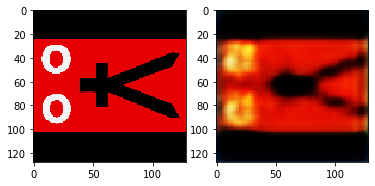

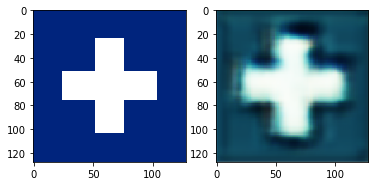

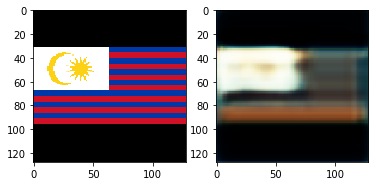

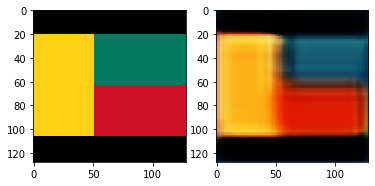

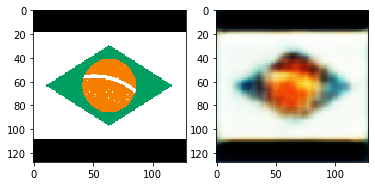

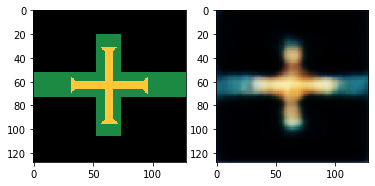

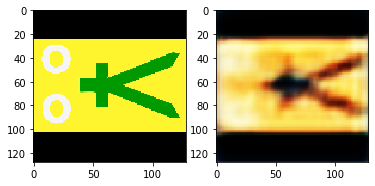

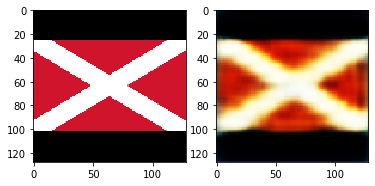

In [109]:
for tr_im, pr_im in zip(test_images_set, pred):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(tr_im)
    plt.subplot(1,2,2)
    plt.imshow(pr_im)    

In [54]:
test_im = Image.open('./data/FlagsMashupBot/reals_square_png/arg.png').convert('RGB')
test_im = test_im.resize((IMG_HEIGHT, IMG_WIDTH))
test_ar = np.asarray(test_im) / 255
test_ar = np.expand_dims(test_ar,0)

In [55]:
pred = autoencoder_train.model.predict(test_ar)

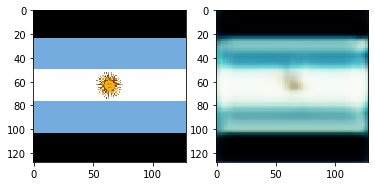

In [56]:
for real, coded in zip(test_ar, pred):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(real)
    plt.subplot(1,2,2)
    plt.imshow(coded)    

### Latent space representation
https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    return OffsetImage(plt.imread(path), zoom=0.15)

In [72]:
info = requests.get('https://restcountries.eu/rest/v2/all')
info = pd.DataFrame(info.json())

In [58]:
latent_model = Model(input_img, encoded)

In [61]:
latent_path = './data/FlagsMashupBot/reals_square_png/'
latent_files = [f for f in os.listdir(latent_path) if f.endswith('.png')]

In [181]:
latent_flags = pd.DataFrame()
for f in latent_files:
    test_im = Image.open(latent_path + f).convert('RGB')
    test_im = test_im.resize((IMG_HEIGHT, IMG_WIDTH))
    test_ar = np.asarray(test_im) / 255
    test_ar_exp = np.expand_dims(test_ar,0)

    latent_pred = latent_model.predict(test_ar_exp)
    code = f.split('.')[0].upper()
    country_info = info[info.alpha3Code == code].iloc[0]
    one = {
        'code': code, 
        'name': country_info.name, 
        'file': f, 
        '3d_latent': np.squeeze(latent_pred[0, :, :, :]),
        '1d_latent': np.ravel(np.squeeze(latent_pred[0, :, :, :])),
        '3d_real': test_ar}
    country_df = pd.DataFrame([one], index = [0])
    latent_flags = latent_flags.append(country_df, ignore_index=True)

In [185]:
latent_tsne = sklearn.manifold.TSNE(n_components=2).fit_transform(np.vstack(latent_flags['1d_latent'].values))

(-17.53103115840625, 15.30703404231738, -12.630210555836591, 14.47854391460124)

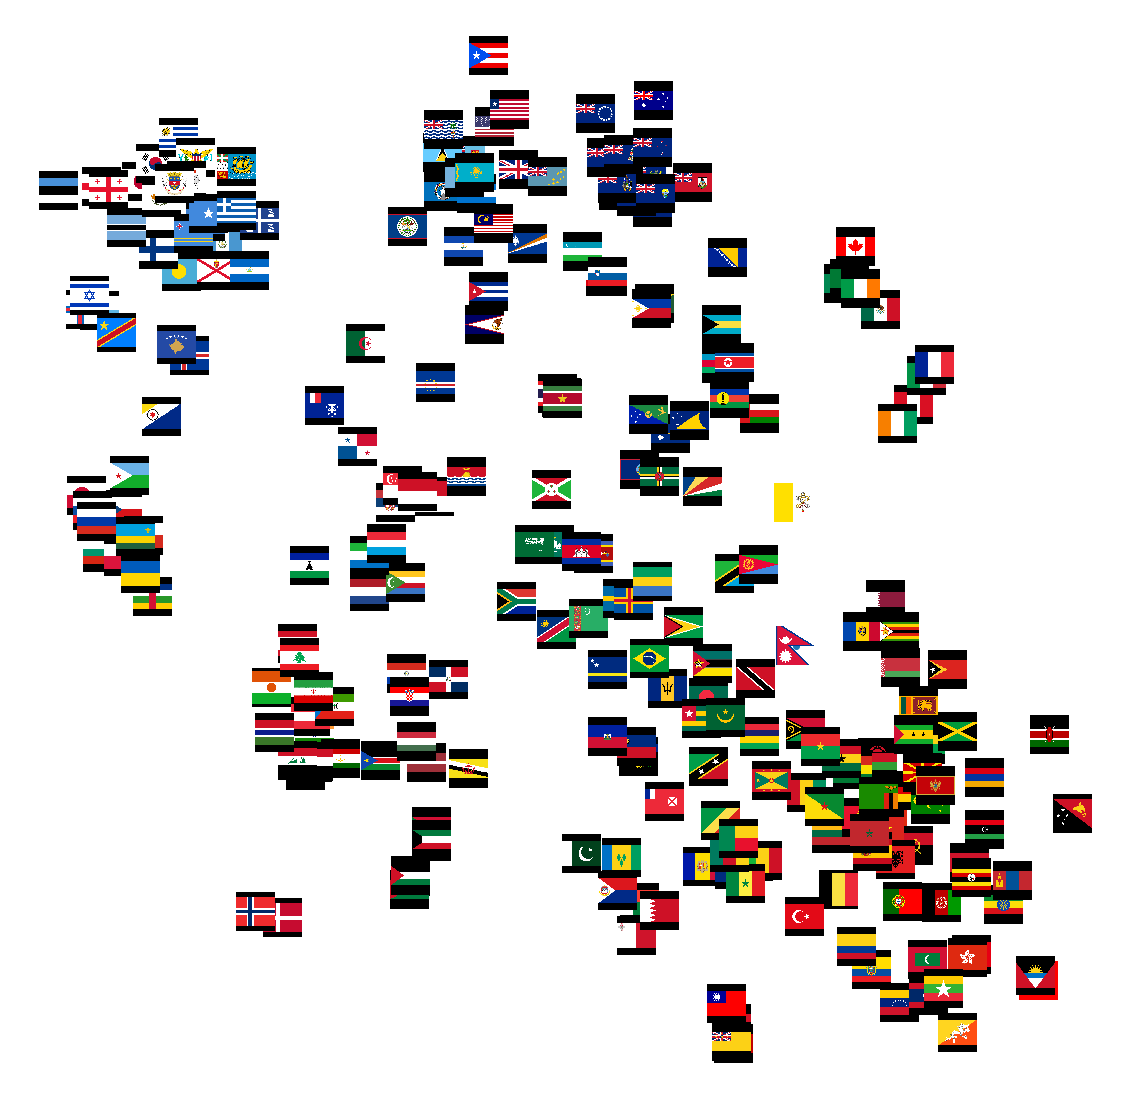

In [196]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(1,1,1)
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1])
for x0, y0, file in zip(latent_tsne[:, 0], latent_tsne[:, 1], latent_files):
    path = latent_path + file
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)
plt.axis('off')
    

In [206]:
real_tsne = sklearn.manifold.TSNE(n_components=2).fit_transform(np.vstack([np.ravel(val3d) for val3d in latent_flags['3d_real'].values]))

(-20.987531116444575,
 19.400212696034423,
 -21.46150423412028,
 19.72787882213298)

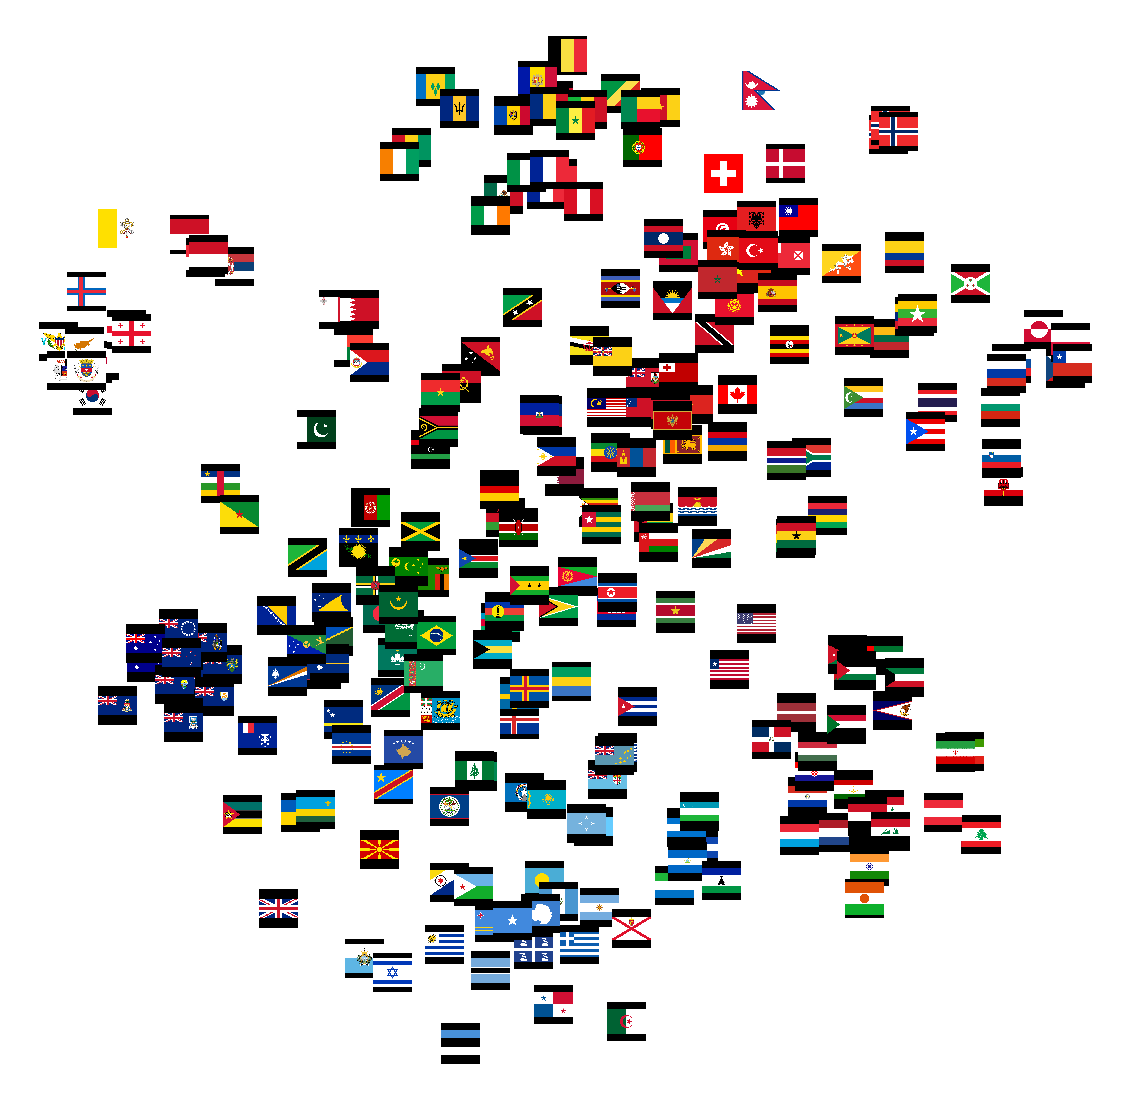

In [207]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(1,1,1)
plt.scatter(real_tsne[:, 0], real_tsne[:, 1])
for x0, y0, file in zip(real_tsne[:, 0], real_tsne[:, 1], latent_files):
    path = latent_path + file
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)
plt.axis('off')
    